## **Fraud Detection Model**

**Used scikit-learn's Isolation Forest technique**


In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score

In [171]:
import warnings
warnings.filterwarnings('ignore')

In [172]:
# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataBytes Files/Sample getTransactions API data.csv')

In [173]:
data = data[["amount","balance","class","postDate"]]

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   amount    289 non-null    float64
 1   balance   289 non-null    float64
 2   class     289 non-null    object 
 3   postDate  289 non-null    object 
dtypes: float64(2), object(2)
memory usage: 9.2+ KB


In [175]:
data["postDate"] = pd.to_datetime(data["postDate"], utc = True)

In [176]:
data["Year"] = data["postDate"].apply(lambda time: time.year)
data["Month"] = data["postDate"].apply(lambda time: time.month)
data["Day"] = data["postDate"].apply(lambda time: time.day)
data["Hour"] = data["postDate"].apply(lambda time: time.hour)
data["Minutes"] = data["postDate"].apply(lambda time: time.minute)
data["Seconds"] = data["postDate"].apply(lambda time: time.second)

In [177]:
data["Date"] = data["postDate"].dt.strftime("%d%m%y")

In [178]:
data["Time"] = data["postDate"].dt.strftime("%H%M%S")

In [179]:
data = data.drop(columns={"postDate"})

In [180]:
data = data.loc[:,["amount","balance","class"]]

In [181]:
np.unique(data.loc[:,["class"]])

array(['bank-fee', 'cash-withdrawal', 'payment', 'transfer'], dtype=object)

In [182]:
def encode(x):
  if x == "bank-fee" : return 1
  if x == "cash-withdrawal" : return 2
  if x == "payment" : return 3
  if x == "transfer" : return 4

data["class"] = data["class"].apply(encode)

In [183]:
clf=IsolationForest(n_estimators=200, max_samples='auto', contamination=float(.12), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(data)
pred = clf.predict(data)
data['anomaly']=pred
outliers = data.loc[data['anomaly']==-1]
outlier_index = list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(data['anomaly'].value_counts())

 1    254
-1     35
Name: anomaly, dtype: int64


In [184]:
data

,amount,balance,class,anomaly
0,-200.0,22109.56,2,-1
1,-2.5,22309.56,1,-1
2,-200.0,22312.06,2,-1
3,-2.5,22512.06,1,-1
4,-3852.5,22514.56,3,-1
...,...,...,...,...
284,201.0,-357.34,4,1
285,201.0,-558.34,4,1
286,-500.0,-759.34,3,1
287,-160.0,-259.34,3,1


#### **3D plot**

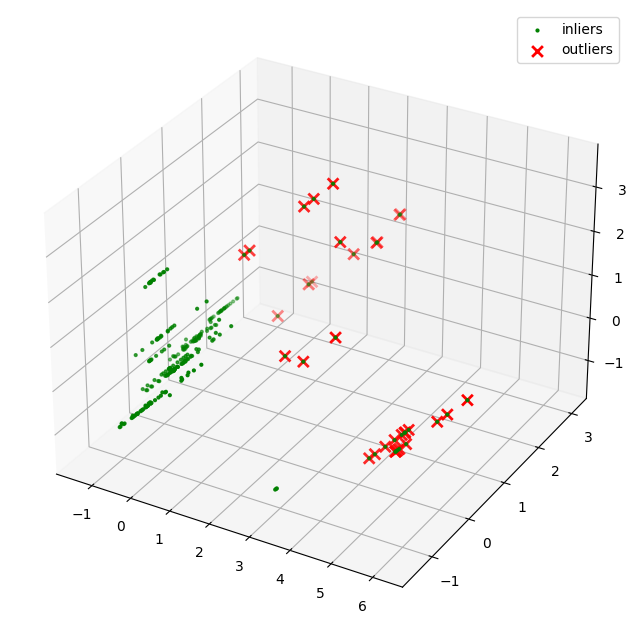

In [185]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(data)
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2], lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

#### **2D plot**

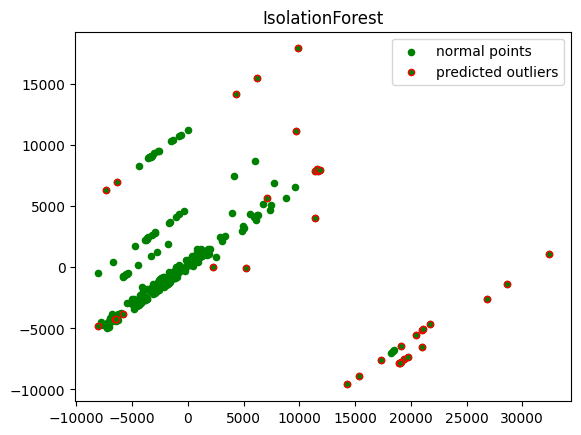

In [186]:
pca = PCA(2)
pca.fit(data)
res = pd.DataFrame(pca.transform(data))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green', s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

### Date Excluded

In [187]:
from sklearn.preprocessing import MinMaxScaler

In [188]:
anomaly_inputs = ["amount", "balance","class"]

In [189]:
clf.fit(data[anomaly_inputs])

IsolationForest(contamination=0.12, n_estimators=200, n_jobs=-1,
                random_state=42)

In [190]:
data["anomaly_scores"] = clf.decision_function(data[anomaly_inputs])
data["anomalies"] = clf.predict(data[anomaly_inputs])

In [191]:
data.loc[:,["amount", "balance","class","anomaly_scores","anomalies"]]

,amount,balance,class,anomaly_scores,anomalies
0,-200.0,22109.56,2,-0.033760,-1
1,-2.5,22309.56,1,-0.104885,-1
2,-200.0,22312.06,2,-0.033140,-1
3,-2.5,22512.06,1,-0.109361,-1
4,-3852.5,22514.56,3,-0.038777,-1
...,...,...,...,...,...
284,201.0,-357.34,4,0.045789,1
285,201.0,-558.34,4,0.032035,1
286,-500.0,-759.34,3,0.031768,1
287,-160.0,-259.34,3,0.071106,1


In [192]:
mms = MinMaxScaler()

data.loc[:,['amount','balance']] = mms.fit_transform(data.loc[:,['amount','balance']])

In [193]:
def outlier_plot(data, outlier_method_name, x_var, y_var, xaxis_lim=[0,1], yaxis_lim=[0,1]):

  print(f"Outlier Method: {outlier_method_name}")

  method = f"{outlier_method_name}_anomaly"

  print(f"Number of Anomalous values {len(data[data['anomalies'] == -1])}")
  print(f"Number of Non-Anomalous values {len(data[data['anomalies'] == 1])}")
  print(f"Total number of values: {len(data)}")

  g = sns.FacetGrid(data, col='anomalies', height=4, hue='anomalies', hue_order = [1,-1])
  g.map(sns.scatterplot, x_var, y_var)
  g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight = 'bold')
  g.set(xlim = xaxis_lim, ylim = yaxis_lim)
  axes = g.axes.flatten()
  axes[0].set_title(f"Outliers\n{len(data[data['anomalies'] == -1])} points")
  axes[1].set_title(f"Inliers\n {len(data[data['anomalies'] == 1])} points")
  return g

Outlier Method: Isolation Forest
Number of Anomalous values 35
Number of Non-Anomalous values 254
Total number of values: 289


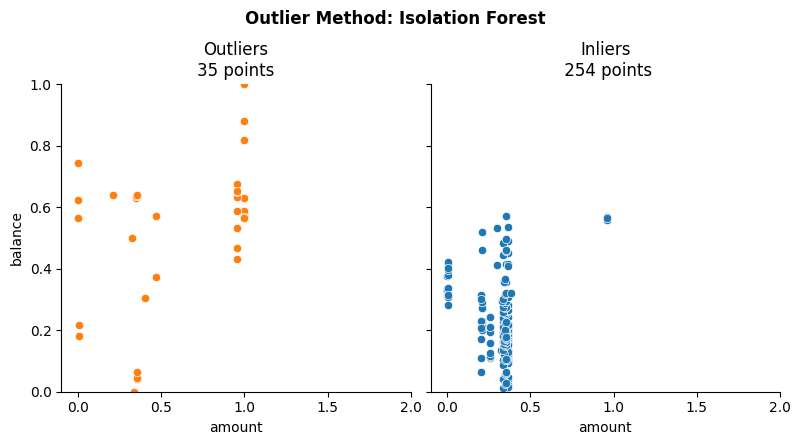

In [194]:
outlier_plot(data, "Isolation Forest", "amount", "balance", [-0.1,2], [0,1])

In [195]:
anomaly_inputs = ["amount", "balance", "class"]

In [196]:
data["anomaly_scores"] = clf.decision_function(data[anomaly_inputs])
data["anomalies"] = clf.predict(data[anomaly_inputs])

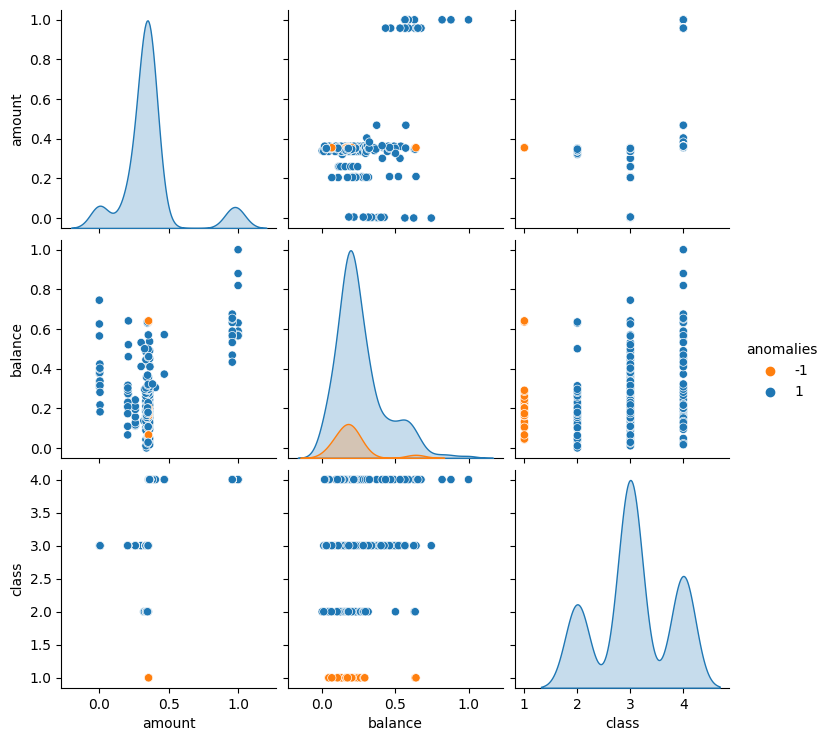

In [197]:
palette = ['#ff7f0e','#1f77b4']
sns.pairplot(data, vars=anomaly_inputs, hue='anomalies', palette=palette)

In [220]:
pickle.dump(clf, open("model.pkl","wb"))
model = pickle.load(open("model.pkl","rb"))